In [57]:
IRdisplay::display_html("
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
body.rise-enabled div.inner_cell>div.input_area {
    font-size: 150%;
}

body.rise-enabled div.output_subarea.output_text.output_result {
    font-size: 150%;
}
body.rise-enabled div.output_subarea.output_text.output_stream.output_stdout {
  font-size: 150%;
}
</style>
")

In [58]:
library(tidyverse)
library(nycflights13)

# Lecture 18: Functional programming & applications

## Review questions
A couple of things that came up in OH and on Canvas:

### `while` vs. `for`
There were some questions in OH about `while` versus `for`. We generally use `for`. They are somewhat equivalent:
```{r}
for (i in 1:n) {
    <body>
}
```
is the same as 
```{r}
i = 1
while (i <= n) {
    <body>
    i = i + 1
}
```

### Anonymous functions
An anonymous function is, literally, a function with no name. Some of the problems on PS8 use this, e.g.:
```{r}

int01(function(x) x)
#     ^^^^^^^^^^^^^^
#   anonymous function
```
You should generally only use these for small, simple functions (max 1 line, no `{}` braces).

## Iterating over multiple sequences at once
Sometimes we want to iterate over multiple sequences. For example, suppose we had a vector `mu` of means and an equal length vector `sigma` of standard deviations. For each pair `mu[[i]],sigma[[i]]` we would like to generate a five standard normal random variable using `rnorm`.

Using `map`, we could accomplish this by

In [100]:
mu = c(5, 10, -3)
sigma = c(1, 5, 10)

1:3 %>% map_dbl(~ rnorm(
    mean = mu[[.]], sd = sigma[[.]], n = 1))

[1]  4.675730 10.300802 -8.888945

Because we don't yet know how to `map` over more than one sequence at a time, we are forced to "hack it" by iterating over `seq_along(mu)`. This hides the true intent of what we set out to accomplish, which is to perform a map over *pairs* of `(mu[i], sigma[i])`.

To iterate over two sequences at once we have the `map2` command:
```{r}
map2(seq1, seq2, f, ...)
```
will call `f(seq1[[i]], seq2[[i]], ...)` for each value of `i`. Indeed, `map2` is equivalent to:
```{r}
map2 <- function(x, y, f, ...) {
  out <- vector("list", length(x))
  for (i in seq_along(x)) {
    out[[i]] <- f(x[[i]], y[[i]], ...)
  }
  out
}
```

`map2` lets us succinctly rewrite the sampling code given above:

In [107]:
map2_dbl(mu, sigma, rnorm, n = 1)

[1]  6.058483 14.432113 -9.192430

## Predicates
Predicates are functions that allow you to filter out elements of sequences based on a condition. The `keep(f)` command will return a new sequence consisting of each element where `f` evaluates to `TRUE`:

In [113]:
#mpg %>% keep(is.numeric) %>% print
#for (col in mpg) {
#    print(is.numeric(col))
#}
str(mpg)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	234 obs. of  11 variables:
 $ manufacturer: chr  "audi" "audi" "audi" "audi" ...
 $ model       : chr  "a4" "a4" "a4" "a4" ...
 $ displ       : num  1.8 1.8 2 2 2.8 2.8 3.1 1.8 1.8 2 ...
 $ year        : int  1999 1999 2008 2008 1999 1999 2008 1999 1999 2008 ...
 $ cyl         : int  4 4 4 4 6 6 6 4 4 4 ...
 $ trans       : chr  "auto(l5)" "manual(m5)" "manual(m6)" "auto(av)" ...
 $ drv         : chr  "f" "f" "f" "f" ...
 $ cty         : int  18 21 20 21 16 18 18 18 16 20 ...
 $ hwy         : int  29 29 31 30 26 26 27 26 25 28 ...
 $ fl          : chr  "p" "p" "p" "p" ...
 $ class       : chr  "compact" "compact" "compact" "compact" ...


`discard()` does the opposite of `keep()`:

In [4]:
mpg %>% discard(is_integer) %>% print

# A tibble: 234 x 7
   manufacturer model      displ trans      drv   fl    class  
   <chr>        <chr>      <dbl> <chr>      <chr> <chr> <chr>  
 1 audi         a4           1.8 auto(l5)   f     p     compact
 2 audi         a4           1.8 manual(m5) f     p     compact
 3 audi         a4           2   manual(m6) f     p     compact
 4 audi         a4           2   auto(av)   f     p     compact
 5 audi         a4           2.8 auto(l5)   f     p     compact
 6 audi         a4           2.8 manual(m5) f     p     compact
 7 audi         a4           3.1 auto(av)   f     p     compact
 8 audi         a4 quattro   1.8 manual(m5) 4     p     compact
 9 audi         a4 quattro   1.8 auto(l5)   4     p     compact
10 audi         a4 quattro   2   manual(m6) 4     p     compact
# ... with 224 more rows


Again, these examples work because *data frames/tibble are lists*.

`detect(f)` and `detect_index(f)` return the first element (or its index) where `f` evaluates to `TRUE`:

In [54]:
rnorm(1000) %>% detect(~ . > 2)

[1] 2.329436

In [8]:
rnorm(1000) %>% detect_index(~ abs(.) > 10)

[1] 0

## The `reduce` function
The last bit of functional programming we will study is `reduce()`. The reduce function takes a “binary” function (i.e. a function with two primary inputs), and applies it repeatedly to a list until there is only a single element left. This takes a little bit of getting used to, but ends up being very powerful.

Let's take a simple example: summing up numbers. If I wanted to add the numbers 1 through 4 I could of course type `sum(1:4)` and get `10`. Suppose I did not know about sum. I could also write:

```{r}
> 1 + 2 + 3 + 4
[1] 10
```

We can rewrite this sum as 
```{r}
> (((1 + 2) + 3) + 4)
[1] 10
```
If $f(x,y) = x + y$ then we can rewrite this as 
$$f(
f(
f(1,2),
3),
4).
$$

In [118]:
f <- function(x, y) x * y
reduce(1:10, f)

[1] 3628800

[1] 3628800

Obviously this is a silly thing to do for computing a simple sum, but the pattern of repeatedly applying a binary function $f(x,y)$, where $y$ is the output from a previous application of the function, actually turns up a lot in programming. The `reduce` function accomplishes this for us:

In [119]:
reduce(1:4, `+`)

[1] 10

## `accumulate`
A closely related variant of `reduce` is `accumulate`. In the above example, instead of returning 

$$f(1, f(2, f(3, 4)))$$

accumulate would return a *vector* containing
all of the partially evaluated sums:

$$\texttt{accumulate(f, 1:44)} = (f(1, 2), f(f(1, 2), 3), f(f(f(1, 2), 3), 4))$$

In [8]:
1:4 %>% accumulate(`+`)

[1]  1  3  6 10

### Example
Suppose we have a list of vectors $(v_1,\dots,v_n)$ and we want to find their intersection. Mathematically this equals $$I_n:=\bigcap_{i=1}^n v_n=v_n\cap I_{n-1},$$ so we can use reduce to compute it:

In [11]:
vs = list(
  c(1, 3, 5, 6, 10),
  c(1, 2, 3, 7, 8, 10),
  c(1, 2, 3, 4, 8, 9, 10)
)
vs %>% reduce(intersect)

[1]  1  3 10

### Exercise
Let's say we want to concatenate together a bunch of strings, and because we haven't been coming to lecture we don't know about `str_c`. In fact, we only know about the following function which concatenates just two strings at a time:

In [14]:
cat2 = function(x, y, ...) {
    paste0(x, y, ...)
}

Use `cat2` and `reduce` to build a function which will concatenate whole vectors of strings together.

Let's think about what our new function will do. If we pass it the vector `c('a','b','c','d')` we should get back the string `'abcd'`. We could accomplish this using `cat2`:

In [15]:
v = c('a', 'b', 'c', 'd')
cat2(cat2(cat2(v[1], v[2]), v[3]), v[4])

[1] "abcd"

This pattern suggests how we might use `reduce`:

In [18]:
v %>% reduce(cat2)

[1] "abcd"

### Exercise
Given a vector $v$, the *cumulative product* of $v$ is a vector $p$ such that $$p_j = \prod_{i=1}^j v_i.$$
For example, the cumulative product of $(1,2,3,4)$ is $(1,2,6,24)$ (i.e. the factorials). 

Use `accumulate` to write a function `cumprod(v)` that computes the cumulative product.

In [20]:
1:10 %>% accumulate(~ .x * .y)

 [1]       1       2       6      24     120     720    5040   40320  362880
[10] 3628800

## Closures
When we create a function
```{r}
f = function(x) {
    <do somethings with x>
}
```
that function has access to:
- all of the variables defined inside the function (its arguments plus whatever other variables we create in the body of the function), *as well as*
- all of the variables defined "outside" the function.

Example:

In [121]:
y = 1
f = function(x) {
    x + y
}
f(1)
y <- 2
f(1)

[1] 2

[1] 3

Now `f` is a function that will add one to its argument:

In [30]:
f(1)

[1] 2

In fact, we can change the behavior of `f` by changing `y`. Observe:

In [34]:
y = 2
f(1)  # now f adds 2 to x

[1] 3

In [35]:
y = NA
f(1) 

[1] NA

In this example `f` is what's called a *closure*, because it *encloses* all the variables defined outside of `f`, as well as those defined inside of it.

Closures become useful when we think about creating functions inside of other functions:

In [47]:
power = function(exponent) {
  function(x) {
    x ^ exponent
  }
}
square = power(2)
cube = power(3)

What is `square` now? It's a function:

In [49]:
square(3)
cube(4)

[1] 9

[1] 64

As we said, `square` is a closure. The list of variables it encloses is called its *environment*. You can look at this list by using the command of that name:

In [50]:
square
as.list(environment(square))

function(x) {
    x ^ exponent
  }
<environment: 0x7fe8b18b6958>

$exponent
[1] 2


In [53]:
as.list(environment(cube))

$exponent
[1] 3


### Memoization
A good use for closures is something called *memoization*. Memoization lets you save the results of a function call for future use. This is very useful in combination with recursion.

To implement memoization, we define a list in the enclosing enviroment of the function we wish to memoize. Then, each time we call the function, we check to see if the value is already saved in the list. If so, we return it; otherwise, we do the computation and store it for future use.

Consider the following recursive function:

In [150]:
memo <- vector("integer", 200)
f.slow = function(k) {
    if (k == 1) return(1)
    k * f.slow(k - 1)
}

f.fast = function(k) {
    if (memo[[k]] != 0)
        return(memo[[k]])
    if (k == 1) 
       return(1)
    answer = k * f.fast(k - 1)
    memo[[k]] = answer
    return(answer)
}
f.slow(20)
f.fast(20) 

[1] 2.432902e+18

[1] 2.432902e+18

This function is slow to compute for large $k$:

In [152]:
library(microbenchmark)
microbenchmark(
    f.fast(50),
    f.slow(50)
) %>% print

Unit: microseconds
       expr    min     lq      mean  median      uq     max neval
 f.fast(50) 82.497 85.167 115.50995 95.0325 117.868 659.053   100
 f.slow(50) 19.460 21.564  25.32479 23.6770  27.921  56.909   100


To speed up `f` we will memoize it:

In [24]:
memo = rep(NA_real_, 100)
fmemo = function(k) {
    if (is.na(memo[[k]])) {
        ret = NA
        if (k <= 2) {
            ret = 1
        } else {
            ret = k^2 * fmemo(k - 1) - k * fmemo(k - 2)
        }
        memo[[k]] <<- ret
    }
    memo[[k]]
}

Note the use of the `<<-` operator. This is required in order to make assignments to the enclosed variable `memo`.

In [25]:
library(microbenchmark)
microbenchmark(
    f(10),
    f(20),
    fmemo(10),
    fmemo(20)
) %>% print

Unit: nanoseconds
      expr     min        lq       mean  median        uq     max neval
     f(10)   40626   41916.0   45247.92   42941   46218.5   68022   100
     f(20) 5050269 5237409.0 5659128.15 5334692 5606398.5 9841770   100
 fmemo(10)     542     703.5   85840.19     841    2830.5 8390247   100
 fmemo(20)     566     699.5    2150.37     905    3075.5   20581   100


## Application: analyzing cancer expression data
Why do we care about functional programming? Here is a real-life example. A *DNA microarray* is a chip that measures the expression levels of different genes. It can be used to diagnose different types of cancer:
![genes](https://d9aqs07uebq07.cloudfront.net/content/clinchem/48/8/1170/F2.large.jpg?download=true)

In [9]:
# ### training data
# filename <- paste("http://pubs.broadinstitute.org/mpr/projects/",
# "Global_Cancer_Map/GCM_Training.res", sep="")
# dat0 <- read.delim(filename, sep="\t", header=FALSE, skip=3, quote="")
# tmp <- dat0[,1:290]
# tmp <- tmp[, -seq(4, 290, by=2)]
# tmp <- tmp[, -(1:2)]
# train <- t(tmp)
# filename <- paste("http://pubs.broadinstitute.org/mpr/projects/",
# "Global_Cancer_Map/GCM_Training.cls", sep="")
# train.classes <- read.table(filename, skip=2)+1
# train.classes <- unlist(train.classes)
# ### test data
# filename <- paste("http://pubs.broadinstitute.org/mpr/projects/",
# "Global_Cancer_Map/GCM_Test.res", sep="")
# dat0 <- read.delim(filename, sep="\t", header=FALSE, skip=3, quote="")
# tmp <- dat0[,1:110]
# tmp <- tmp[, -seq(4, 110, by=2)]
# tmp <- tmp[, -(1:2)]
# test <- t(tmp)[1:46,]
# filename <- paste("http://pubs.broadinstitute.org/mpr/projects/",
# "Global_Cancer_Map/GCM_Test.cls", sep="")
# test.classes <- read.table(filename, skip=2)+1
# test.classes <- test.classes[test.classes!=15]
# test.classes <- unlist(test.classes)
# tr <- as_tibble(train) %>% mutate(class = train.classes, split="train")
# ts <- as_tibble(test) %>% mutate(class = test.classes, split="test")
# gcm14 <- bind_rows(tr, ts)

The dataset `gcm14.RData` contains gene expression measurements for 190 patients and 16,063 genes:

In [29]:
load("gcm14.RData")
print(gcm14)

# A tibble: 190 x 16,065
   class split    V1    V2    V3    V4    V5    V6    V7    V8    V9   V10   V11
   <fct> <chr> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
 1 1     train   -73   -69   -48    13   -86  -147   -65   -71   -32   100   -73
 2 1     train   -16   -63   -97   -42   -91  -164   -53   -77   -17   122   -64
 3 1     train     4   -45  -112   -25   -85  -127    56  -110    81    41   -70
 4 1     train   -31  -110   -20   -50  -115  -113   -17   -40   -17    80    -2
 5 1     train   -33   -39   -45    14   -56  -106    73   -34    18    64   -35
 6 1     train   -37   -90   -75   -46   -45  -129    87   -49    50     3   -80
 7 1     train   -18    28    10    30   -56  -200   149   -87    -2    95   -74
 8 1     train   -26   -23     2    34   -54   -30   -12   -25    -6    69   -12
 9 2     train   -40  -264  -335    18  -163  -208   138  -113    16   -15     2
10 2     train    22   -14   -21    26   -42   -38   -60   -39    21    64   -67
# .

There are 14 different types of cancer represented in this data set:

In [30]:
fct_count(gcm14$class)

   f  n 
1  1  11
2  2  10
3  3  11
4  4  11
5  5  22
6  6  11
7  7  10
8  8  10
9  9  30
10 10 11
11 11 11
12 12 11
13 13 11
14 14 20

The actual measurements look like:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


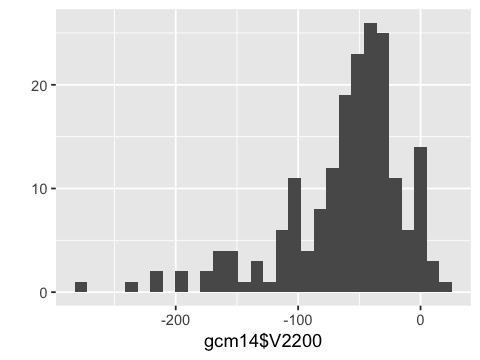

In [155]:
qplot(gcm14$V2200, geom="histogram")

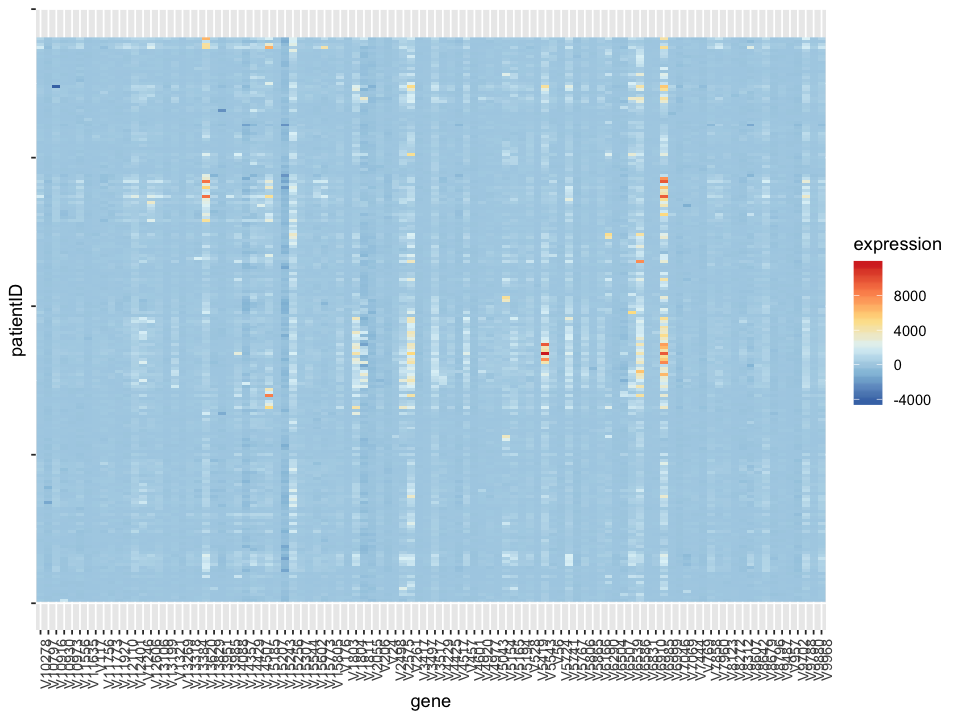

In [159]:
options(repr.plot.width=8, repr.plot.height=6)
gcm14 %>% select(1, 2, sample(3:ncol(gcm14), size=100)) %>% 
    mutate(patientID=row_number()) %>% 
    gather(key=gene, value=expression, -class, -split, -patientID) %>% 
    ggplot(aes(x=gene, y=patientID, fill=expression)) + geom_raster() +
    scale_fill_distiller(palette = "RdYlBu") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
          axis.text.y = element_blank())

Experts recommend three steps to normalize this data:
- Clip values to the interval $[50, 15000]$
- Filtering to remove genes with $\max/\min \le 5$ or $\max − \min \le 500$
- Transforming by $\log_{10}$

In [180]:
clip <- function(x) pmax(50, pmin(x, 15000))
#for (col in names(gcm14)[3:ncol(gcm14)]) {
#    gcm14[[col]] <- clip(gcm14[[col]])
#}

# predicate <- function(col) {
#     if (!is.numeric(col)) return(TRUE)
#     M = max(col)
#     m = min(col)
#     !(M / m <= 5 || M - m < 500)
# }

# gcm14 <- keep(gcm14, predicate)

# gcm14 <- gcm14 %>% mutate_if(is.numeric, log10)
gcm14 %>% print

# A tibble: 190 x 11,131
   class split    V7   V10   V15   V16   V20   V23   V35   V36   V37   V38   V39
   <fct> <chr> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
 1 1     train  1.70  2     1.70  1.74  2.95  1.70  1.70  1.70  1.70  1.70  1.89
 2 1     train  1.70  2.09  1.70  1.70  1.70  1.70  1.70  1.70  1.70  1.70  1.70
 3 1     train  1.75  1.70  1.70  1.79  1.70  1.70  1.70  1.70  1.80  2.63  2.54
 4 1     train  1.70  1.90  2.26  1.99  1.70  1.70  1.70  1.70  1.70  1.70  1.94
 5 1     train  1.86  1.81  1.70  1.70  1.70  1.70  1.70  1.70  1.70  2.40  2.06
 6 1     train  1.94  1.70  1.70  1.72  1.70  1.70  1.70  1.70  1.70  2.48  2.00
 7 1     train  2.17  1.98  1.70  1.70  1.70  1.70  1.70  1.70  1.92  2.39  1.77
 8 1     train  1.70  1.84  1.70  1.70  1.70  1.70  1.70  1.70  1.70  1.70  1.70
 9 2     train  2.14  1.70  1.70  2.03  1.70  1.70  1.70  1.70  1.88  3.18  1.70
10 2     train  1.70  1.81  1.70  1.70  1.70  1.70  1.70  1.70  1.70  1.70  1.70
# .

In [56]:
dat <- gcm14[,3:100] %>% as.matrix  # numerical columns
row.order <- hclust(dist(dat))$order # clustering
col.order <- hclust(dist(t(dat)))$order

In [55]:
row.order